# AI System Implementation - Exploring difference approches

- dataset: food101

## Importing Library

In [2]:
import math
import time
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

## Downloading dataset

In [3]:
dataset_name = "food101"
train_dataset = tfds.load(dataset_name, split="train", as_supervised=True)
test_dataset = tfds.load(dataset_name, split="validation", as_supervised=True)  # Using predefined test set
info = tfds.builder(dataset_name).info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.K9T2NL_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.K9T2NL_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Understanding the dataset

In [4]:
info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo nu

## Limited Classes

In [5]:
CLASSES = 10 # Number of classes

In [6]:
# Get only the first `CLASSES` labels
selected_classes = tf.constant(list(range(CLASSES)), dtype=tf.int64)
labels = info.features['label'].names[:CLASSES]

# Efficient function to filter dataset based on selected classes
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, selected_classes))

# Apply filtering
filtered_train_dataset = train_dataset.filter(filter_classes)
test_ds = test_dataset.filter(filter_classes)

In [7]:
# Get dataset sizes efficiently
def dataset_size(dataset):
    return dataset.reduce(tf.constant(0), lambda x, _: x + 1).numpy()

train_size = dataset_size(filtered_train_dataset)
test_size = dataset_size(test_ds)

print(f"Filtered Train dataset size: {train_size}")
print(f"Filtered Test dataset size: {test_size}")

Filtered Train dataset size: 7500
Filtered Test dataset size: 2500


## Visaulizing Sample Images

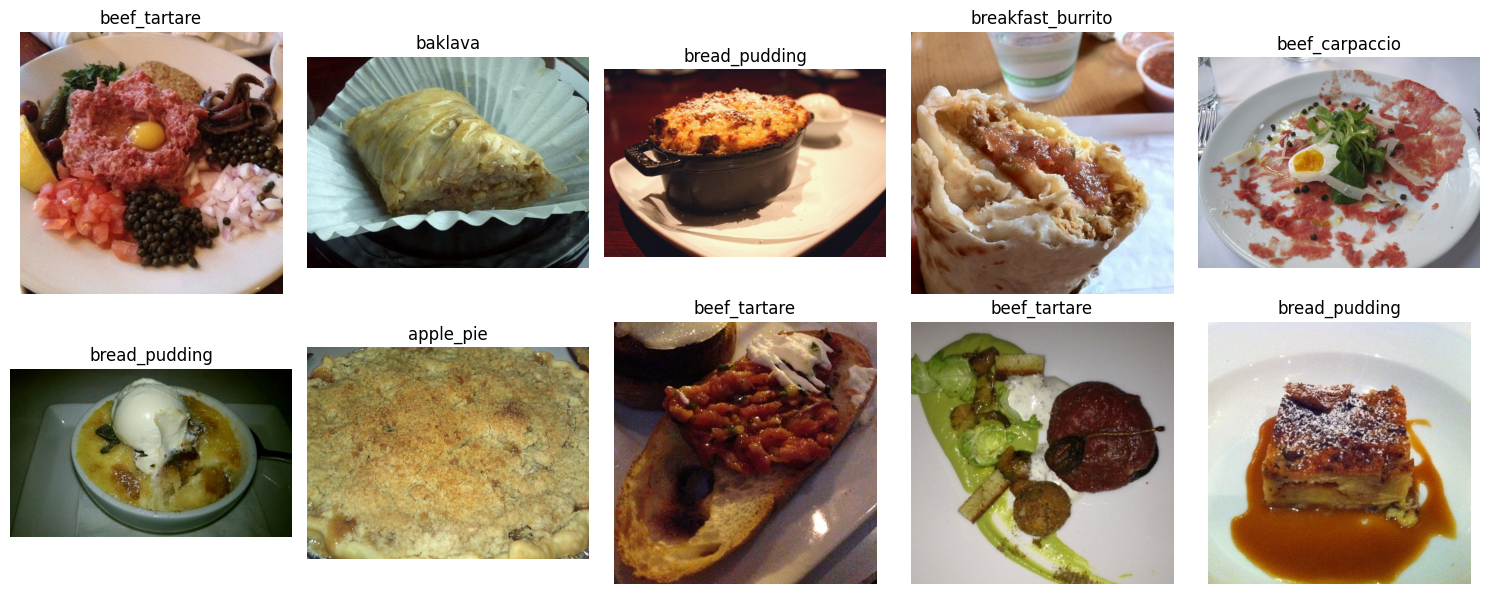

In [8]:
# Dynamically determine the grid size for plotting
cols = min(CLASSES, 5)  # Max 5 columns for better layout
rows = math.ceil(CLASSES / cols)

# Create visualization grid
plt.figure(figsize=(cols * 3, rows * 3))  # Adjust figure size dynamically
for i, (image, label) in enumerate(filtered_train_dataset.take(CLASSES)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(labels[label.numpy()])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Shuffle before Splitting

In [9]:
# Shuffle before splitting (Ensures random train/validation split)
filtered_train_dataset = filtered_train_dataset.shuffle(10000, reshuffle_each_iteration=False)

## Dataset Splitting

In [10]:
train_split = 0.8
full_train_size = train_size
train_size = int(train_split * full_train_size)

train_ds = filtered_train_dataset.take(train_size)
val_ds = filtered_train_dataset.skip(train_size)

train_size = dataset_size(train_ds)
val_size = dataset_size(val_ds)

print(f"Filtered Train set size: {train_size}")
print(f"Filtered Validation set size: {val_size}")

Filtered Train set size: 6000
Filtered Validation set size: 1500


## Feature engineering & Data Augmentation

### Standardizing & Normalizing Pixel Values

In [11]:
# Normalize pixel values to [0,1]
def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Converts from [0, 255] → [0, 1]
    return image, label

### Common Augmentations for Image Classification

In [12]:
# Define augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # Flip images horizontally
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation
    return image, label

### Optimized Data Pipeline

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Optimized processing

## Utility Function

### Image

In [14]:
def get_image_shape(image_size, channels=3):
    return (image_size, image_size, channels)

# Function to resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

def pipeline_preprocessing():
  # Processing Dataset
  train_set = train_ds.repeat().map(resize).map(normalize).map(augment).shuffle(10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
  val_set = val_ds.repeat().map(resize).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
  test_set = test_ds.map(resize).map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

  return train_set, val_set, test_set


### Model

In [15]:
def generate_model (pretraining_model, dense=256, dropout=0.6, learning_rate=1e-4):
  base_model = pretraining_model(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  base_model.trainable = False

  # Add custom classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(dense, activation="relu")(x)
  x = Dropout(dropout)(x)

  output_layer = Dense(CLASSES, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  return base_model, model

def fine_tune_model (base_model, model, learning_rate=1e-5):
  base_model.trainable = True

  # Recompile model with lower learning rate
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return model

In [16]:
def train_model (model, train_set, val_set):
  STEPS_PER_EPOCH = train_size // BATCH_SIZE  # Calculate number of steps per epoch
  VALIDATION_STEPS = val_size // BATCH_SIZE   # Same for validation

  early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=5,  # Wait 5 epochs before stopping
    restore_best_weights=True  # Keep the best model
  )

  lr_scheduler = ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.5,  # Reduce by half
      patience=3,  # Wait 3 epochs
      min_lr=1e-6
  )

  # Train model
  start_time = time.time()
  # Train model with early stopping
  history = model.fit(
      train_set,
      validation_data=val_set,
      epochs=EPOCHES,
      steps_per_epoch=STEPS_PER_EPOCH,
      validation_steps=VALIDATION_STEPS,
      callbacks=[early_stopping, lr_scheduler]
  )
  end_time = time.time()
  training_time = end_time - start_time

  return history, training_time, model

### Graph

In [17]:
def plot_accuracy_n_loss(history):
    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [18]:
def gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time):
  # Generate predictions on validation dataset
  # Store predictions in TensorFlow tensors (avoids NumPy conversion issues)
  STEPS = math.ceil(test_size / BATCH_SIZE)
  y_true = tf.concat([labels for _, labels in test_set], axis=0)
  y_pred = tf.argmax(model.predict(test_set, steps=STEPS), axis=1)

  # Classification Report
  class_report = classification_report(y_true, y_pred, target_names=labels)
  print(class_report)

  # Calculate average accuracy and loss for training and validation (before fine-tuning)
  avg_train_acc = np.mean(history.history['accuracy'])
  avg_val_acc = np.mean(history.history['val_accuracy'])
  avg_train_loss = np.mean(history.history['loss'])
  avg_val_loss = np.mean(history.history['val_loss'])

  # Calculate average accuracy and loss for training and validation (after fine-tuning)
  avg_train_acc_fine = np.mean(fine_tune_history.history['accuracy'])
  avg_val_acc_fine = np.mean(fine_tune_history.history['val_accuracy'])
  avg_train_loss_fine = np.mean(fine_tune_history.history['loss'])
  avg_val_loss_fine = np.mean(fine_tune_history.history['val_loss'])

  # Display results
  print("=== Initial Training ===")
  print(f"Average Training Accuracy: {avg_train_acc:.4f}")
  print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
  print(f"Average Training Loss: {avg_train_loss:.4f}")
  print(f"Average Validation Loss: {avg_val_loss:.4f}\n")

  print("=== After Fine-Tuning ===")
  print(f"Average Training Accuracy (Fine-Tuned): {avg_train_acc_fine:.4f}")
  print(f"Average Validation Accuracy (Fine-Tuned): {avg_val_acc_fine:.4f}")
  print(f"Average Training Loss (Fine-Tuned): {avg_train_loss_fine:.4f}")
  print(f"Average Validation Loss (Fine-Tuned): {avg_val_loss_fine:.4f}")

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

  # Display runtime performance
  print(f"Initial Training Time: {initial_training_time:.2f} seconds")
  print(f"Fine-Tuning Time: {fine_tuning_time:.2f} seconds")

### Variable

In [19]:
BATCH_SIZE = 32
EPOCHES = 100

## Model

### MobileNetV2

#### Build Model

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model, model = generate_model(MobileNetV2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 90s 210ms/step - accuracy: 0.1229 - loss: 2.8593 - val_accuracy: 0.2405 - val_loss: 2.1437 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.2060 - loss: 2.2017 - val_accuracy: 0.2799 - val_loss: 2.0775 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.2314 - loss: 2.1449 - val_accuracy: 0.2921 - val_loss: 2.0219 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.2464 - loss: 2.0912 - val_accuracy: 0.3003 - val_loss: 1.9833 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.2744 - loss: 2.0458 - val_accuracy: 0.3193 - val_loss: 1.9479 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.2818 - loss: 2.0222 - val_accuracy: 0.3431 - val_loss: 1.9309 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━

##### Accuracy and Loss Graph

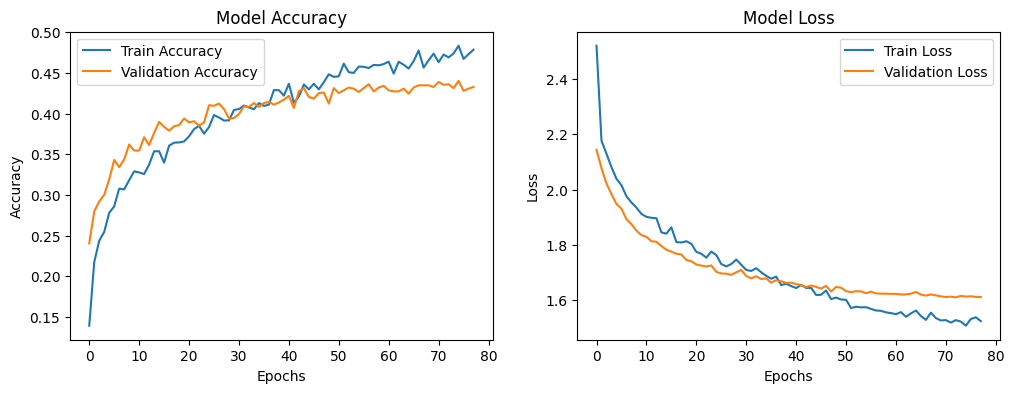

In [ ]:
plot_accuracy_n_loss(history)

#### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 129s 233ms/step - accuracy: 0.2024 - loss: 2.5633 - val_accuracy: 0.3757 - val_loss: 1.8636 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 265ms/step - accuracy: 0.3947 - loss: 1.7179 - val_accuracy: 0.5034 - val_loss: 1.4475 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - accuracy: 0.5189 - loss: 1.3860 - val_accuracy: 0.5978 - val_loss: 1.1481 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.5988 - loss: 1.1570 - val_accuracy: 0.6583 - val_loss: 0.9615 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 265ms/step - accuracy: 0.6433 - loss: 1.0475 - val_accuracy: 0.6923 - val_loss: 0.8604 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.6797 - loss: 0.9181 - val_accuracy: 0.7120 - val_loss: 0.7829 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

##### Accuracy and Loss Graph

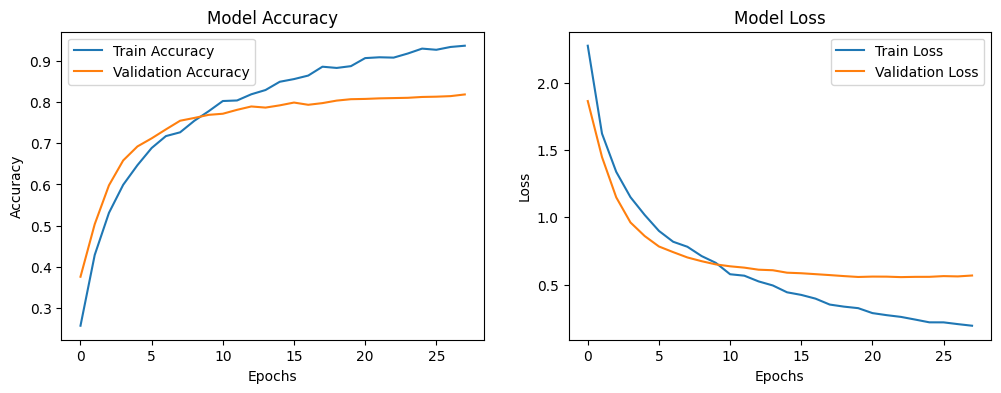

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

#### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step
                   precision    recall  f1-score   support

        apple_pie       0.67      0.67      0.67       250
   baby_back_ribs       0.89      0.90      0.89       250
          baklava       0.83      0.84      0.83       250
   beef_carpaccio       0.86      0.88      0.87       250
     beef_tartare       0.88      0.86      0.87       250
       beet_salad       0.86      0.79      0.82       250
         beignets       0.91      0.94      0.92       250
         bibimbap       0.94      0.95      0.95       250
    bread_pudding       0.69      0.72      0.71       250
breakfast_burrito       0.88      0.88      0.88       250

         accuracy                           0.84      2500
        macro avg       0.84      0.84      0.84      2500
     weighted avg       0.84      0.84      0.84      2500

=== Initial Training ===
Average Training Accuracy: 0.4039
Average Validation Accuracy: 0.4019
Average Training Loss: 1.7079
Aver

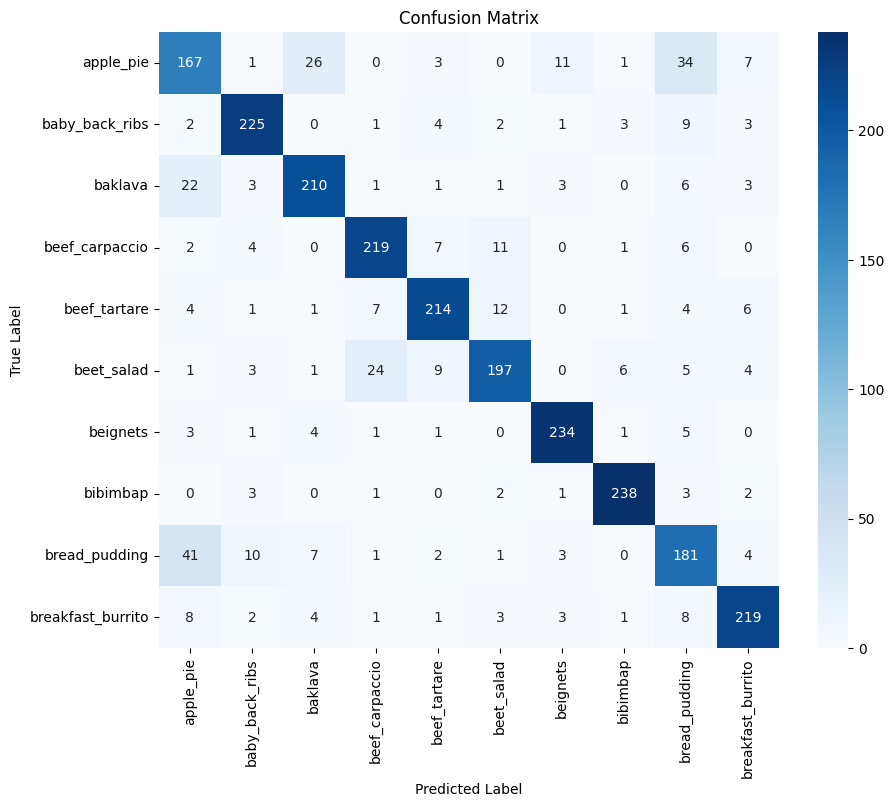

Initial Training Time: 2729.41 seconds
Fine-Tuning Time: 1256.35 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

### EfficientNet

#### B0

##### Build Model

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model, model = generate_model(EfficientNetB0)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 99s 222ms/step - accuracy: 0.2787 - loss: 2.0361 - val_accuracy: 0.7024 - val_loss: 1.1145 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.6340 - loss: 1.1660 - val_accuracy: 0.7493 - val_loss: 0.7939 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.7047 - loss: 0.9160 - val_accuracy: 0.7765 - val_loss: 0.6845 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.7463 - loss: 0.7835 - val_accuracy: 0.7894 - val_loss: 0.6276 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.7678 - loss: 0.6862 - val_accuracy: 0.7982 - val_loss: 0.5928 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.7671 - loss: 0.6858 - val_accuracy: 0.7989 - val_loss: 0.5727 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

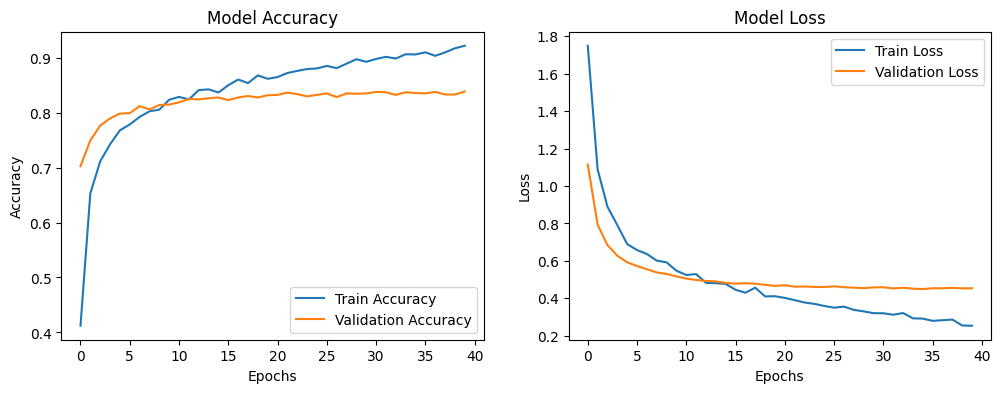

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 159s 264ms/step - accuracy: 0.5700 - loss: 1.2831 - val_accuracy: 0.7452 - val_loss: 0.7215 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.6796 - loss: 0.9812 - val_accuracy: 0.7439 - val_loss: 0.7434 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.7246 - loss: 0.8502 - val_accuracy: 0.7595 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.7760 - loss: 0.6776 - val_accuracy: 0.7731 - val_loss: 0.6389 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.7745 - loss: 0.6684 - val_accuracy: 0.7874 - val_loss: 0.5994 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - accuracy: 0.8151 - loss: 0.5773 - val_accuracy: 0.7989 - val_loss: 0.5701 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

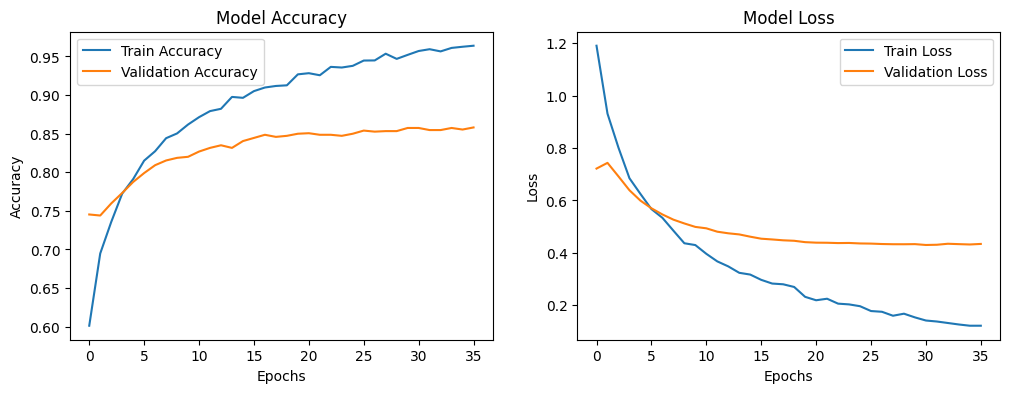

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step
                   precision    recall  f1-score   support

        apple_pie       0.78      0.71      0.74       250
   baby_back_ribs       0.94      0.95      0.95       250
          baklava       0.86      0.91      0.88       250
   beef_carpaccio       0.92      0.91      0.92       250
     beef_tartare       0.91      0.91      0.91       250
       beet_salad       0.90      0.86      0.88       250
         beignets       0.92      0.96      0.94       250
         bibimbap       0.97      0.97      0.97       250
    bread_pudding       0.80      0.80      0.80       250
breakfast_burrito       0.93      0.95      0.94       250

         accuracy                           0.89      2500
        macro avg       0.89      0.89      0.89      2500
     weighted avg       0.89      0.89      0.89      2500

=== Initial Training ===
Average Training Accuracy: 0.8410
Average Validation Accuracy: 0.8202
Average Training Loss: 0.4848
Aver

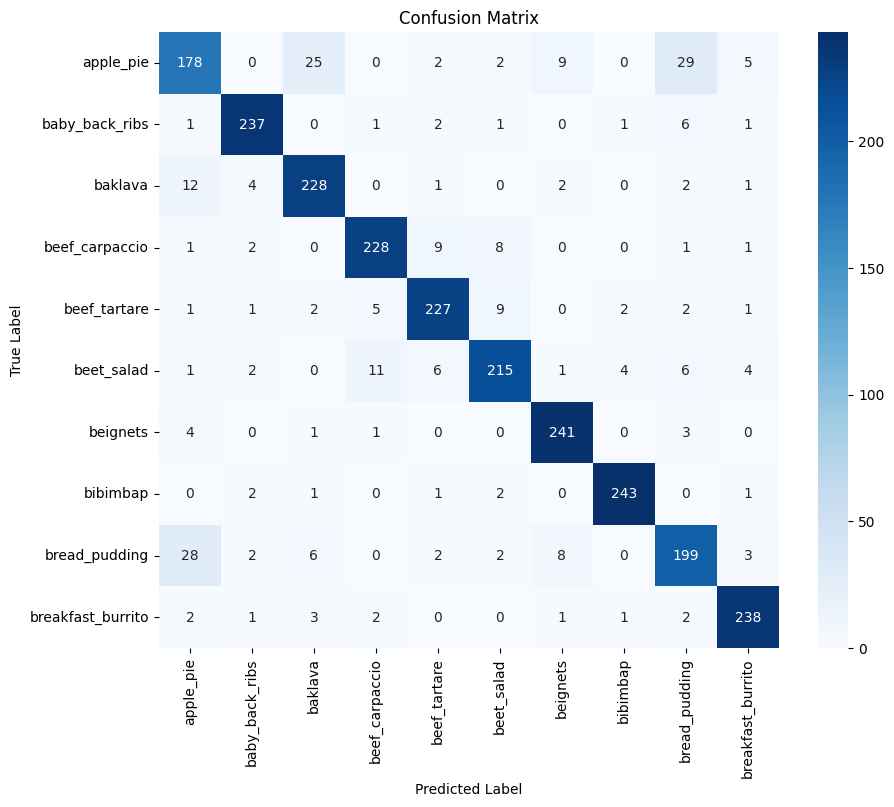

Initial Training Time: 1559.49 seconds
Fine-Tuning Time: 1667.73 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### B1

##### Build Model

In [ ]:
IMG_SIZE = 240
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

base_model, model = generate_model(EfficientNetB1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 240, 240, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 6,905,745 (26.34 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 6,575,239 (25.08 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 113s 238ms/step - accuracy: 0.2474 - loss: 2.1541 - val_accuracy: 0.7011 - val_loss: 1.1437 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.6110 - loss: 1.2263 - val_accuracy: 0.7554 - val_loss: 0.8015 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 253ms/step - accuracy: 0.7128 - loss: 0.9119 - val_accuracy: 0.7901 - val_loss: 0.6799 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.7286 - loss: 0.8131 - val_accuracy: 0.7996 - val_loss: 0.6219 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.7552 - loss: 0.7648 - val_accuracy: 0.8043 - val_loss: 0.5879 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.7643 - loss: 0.7123 - val_accuracy: 0.8193 - val_loss: 0.5600 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

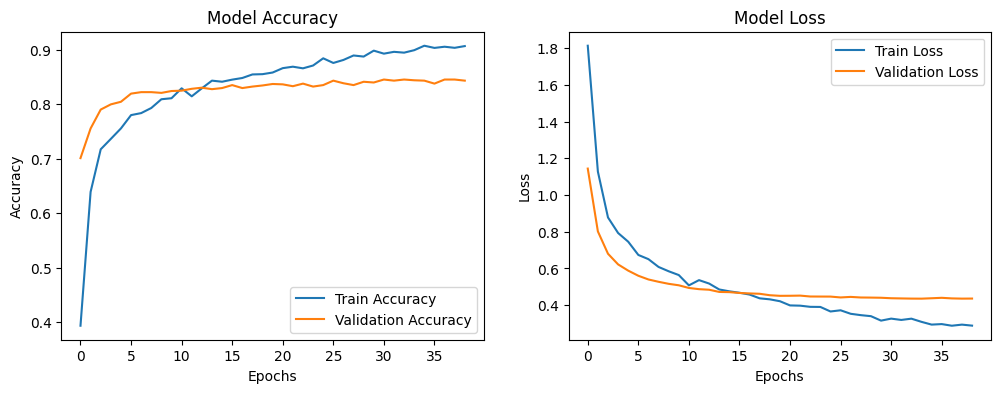

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 201s 314ms/step - accuracy: 0.5473 - loss: 1.3641 - val_accuracy: 0.7520 - val_loss: 0.7408 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 301ms/step - accuracy: 0.6885 - loss: 0.9791 - val_accuracy: 0.7466 - val_loss: 0.7447 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.7371 - loss: 0.8060 - val_accuracy: 0.7745 - val_loss: 0.6721 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 303ms/step - accuracy: 0.7690 - loss: 0.7027 - val_accuracy: 0.7846 - val_loss: 0.6159 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 303ms/step - accuracy: 0.8004 - loss: 0.6175 - val_accuracy: 0.7948 - val_loss: 0.5732 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 302ms/step - accuracy: 0.8229 - loss: 0.5544 - val_accuracy: 0.8084 - val_loss: 0.5413 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

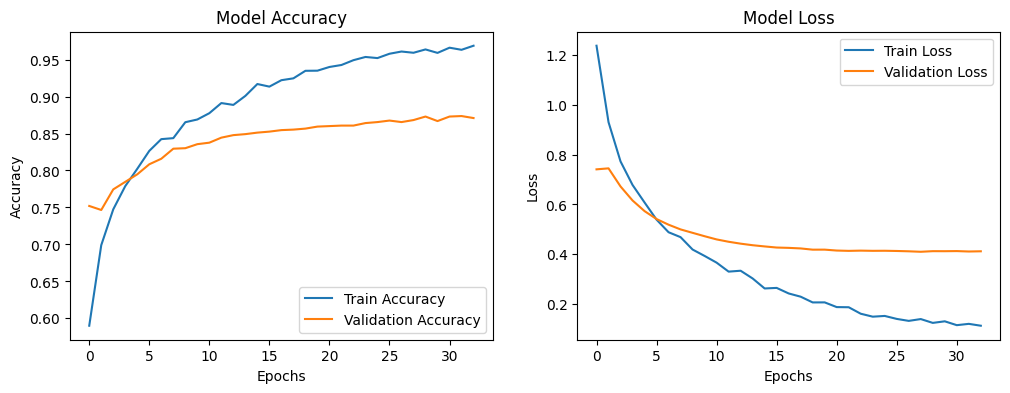

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step
                   precision    recall  f1-score   support

        apple_pie       0.78      0.77      0.77       250
   baby_back_ribs       0.96      0.97      0.97       250
          baklava       0.89      0.91      0.90       250
   beef_carpaccio       0.92      0.91      0.92       250
     beef_tartare       0.91      0.89      0.90       250
       beet_salad       0.88      0.86      0.87       250
         beignets       0.93      0.96      0.94       250
         bibimbap       0.96      0.97      0.97       250
    bread_pudding       0.80      0.81      0.80       250
breakfast_burrito       0.94      0.94      0.94       250

         accuracy                           0.90      2500
        macro avg       0.90      0.90      0.90      2500
     weighted avg       0.90      0.90      0.90      2500

=== Initial Training ===
Average Training Accuracy: 0.8341
Average Validation Accuracy: 0.8264
Average Training Loss: 0.5022
Aver

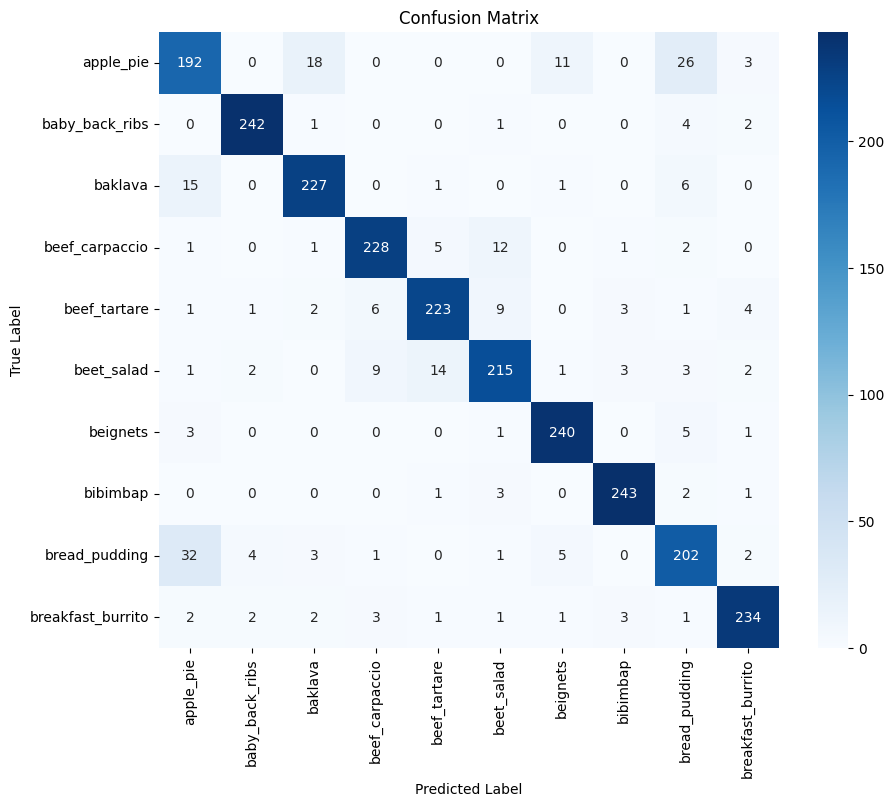

Initial Training Time: 1886.00 seconds
Fine-Tuning Time: 1986.73 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### B2

##### Build Model

In [ ]:
IMG_SIZE = 260
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

base_model, model = generate_model(EfficientNetB2)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 260, 260, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 261, 261, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 130, 130, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 130, 130, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 130, 130, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 8,131,843 (31.02 MB)

 Trainable params: 363,274 (1.39 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 122s 253ms/step - accuracy: 0.3108 - loss: 2.0092 - val_accuracy: 0.7181 - val_loss: 1.0399 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - accuracy: 0.6464 - loss: 1.1186 - val_accuracy: 0.7636 - val_loss: 0.7577 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 262ms/step - accuracy: 0.7215 - loss: 0.8665 - val_accuracy: 0.7792 - val_loss: 0.6677 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - accuracy: 0.7516 - loss: 0.7588 - val_accuracy: 0.7887 - val_loss: 0.6140 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - accuracy: 0.7627 - loss: 0.7053 - val_accuracy: 0.7921 - val_loss: 0.5882 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - accuracy: 0.7774 - loss: 0.6419 - val_accuracy: 0.8030 - val_loss: 0.5563 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

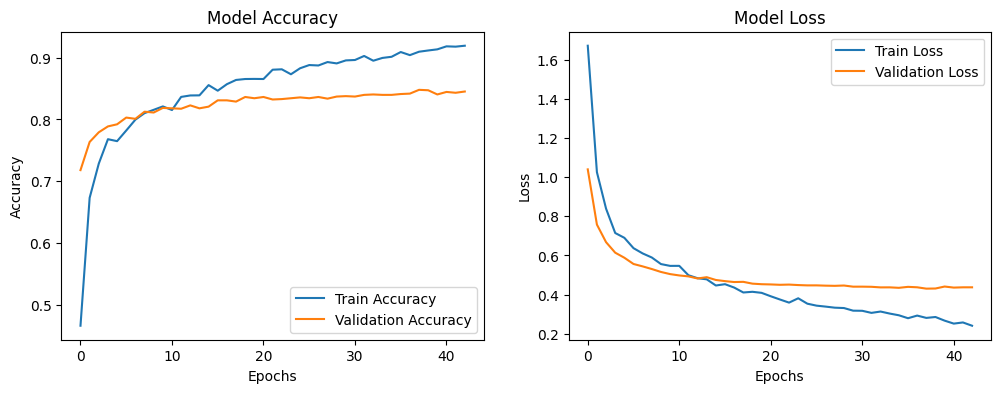

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 217s 352ms/step - accuracy: 0.5774 - loss: 1.2788 - val_accuracy: 0.7500 - val_loss: 0.7009 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.7071 - loss: 0.9172 - val_accuracy: 0.7575 - val_loss: 0.6985 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 331ms/step - accuracy: 0.7774 - loss: 0.7229 - val_accuracy: 0.7785 - val_loss: 0.6296 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 331ms/step - accuracy: 0.8041 - loss: 0.6094 - val_accuracy: 0.7955 - val_loss: 0.5822 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.8161 - loss: 0.5493 - val_accuracy: 0.8105 - val_loss: 0.5461 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 330ms/step - accuracy: 0.8292 - loss: 0.5106 - val_accuracy: 0.8166 - val_loss: 0.5175 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

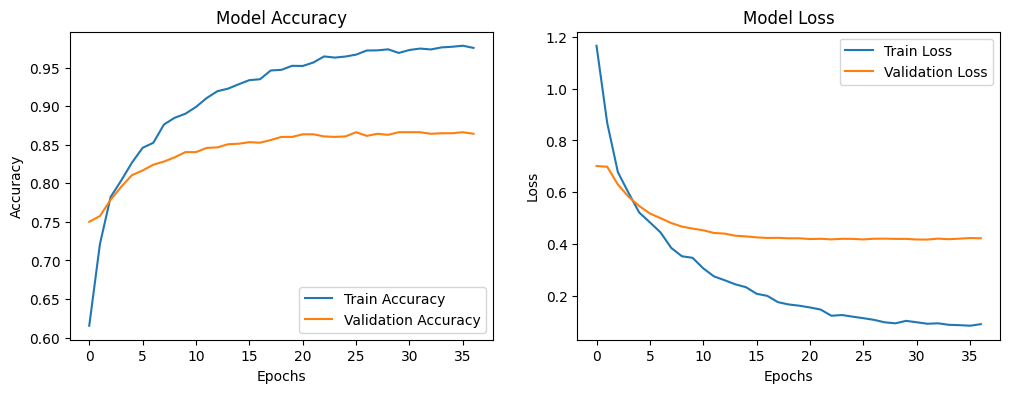

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step
                   precision    recall  f1-score   support

        apple_pie       0.81      0.78      0.79       250
   baby_back_ribs       0.95      0.96      0.95       250
          baklava       0.91      0.92      0.92       250
   beef_carpaccio       0.91      0.94      0.93       250
     beef_tartare       0.90      0.90      0.90       250
       beet_salad       0.90      0.88      0.89       250
         beignets       0.94      0.95      0.95       250
         bibimbap       0.97      0.97      0.97       250
    bread_pudding       0.81      0.82      0.82       250
breakfast_burrito       0.95      0.96      0.95       250

         accuracy                           0.91      2500
        macro avg       0.91      0.91      0.91      2500
     weighted avg       0.91      0.91      0.91      2500

=== Initial Training ===
Average Training Accuracy: 0.8499
Average Validation Accuracy: 0.8242
Average Training Loss: 0.4573
Aver

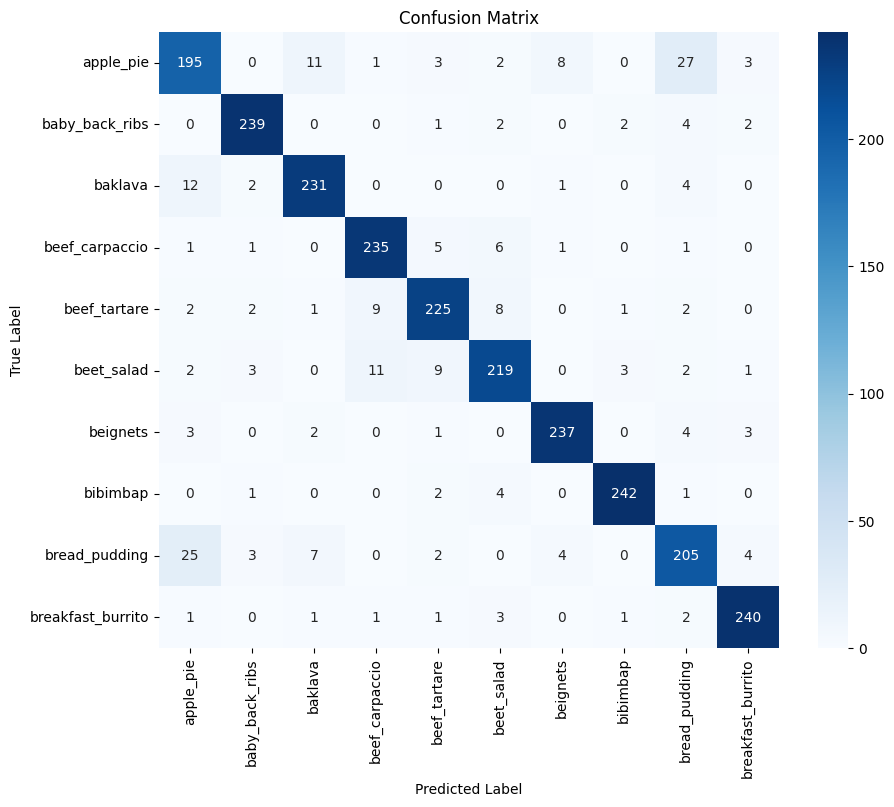

Initial Training Time: 2150.63 seconds
Fine-Tuning Time: 2405.47 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### B3

##### Build Model

In [ ]:
IMG_SIZE = 300
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

base_model, model = generate_model(EfficientNetB3)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 300, 300, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,179,577 (42.65 MB)

 Trainable params: 396,042 (1.51 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 136s 287ms/step - accuracy: 0.3318 - loss: 1.9702 - val_accuracy: 0.7568 - val_loss: 0.9502 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 54s 288ms/step - accuracy: 0.6915 - loss: 0.9950 - val_accuracy: 0.7826 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - accuracy: 0.7393 - loss: 0.8110 - val_accuracy: 0.8043 - val_loss: 0.6100 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 300ms/step - accuracy: 0.7821 - loss: 0.6895 - val_accuracy: 0.8139 - val_loss: 0.5641 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - accuracy: 0.7889 - loss: 0.6301 - val_accuracy: 0.8152 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - accuracy: 0.8095 - loss: 0.5645 - val_accuracy: 0.8261 - val_loss: 0.5167 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

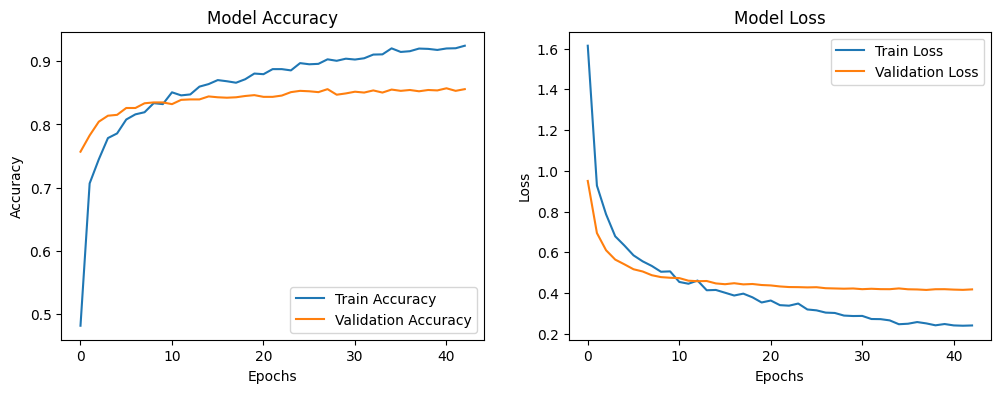

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 261s 480ms/step - accuracy: 0.5737 - loss: 1.2632 - val_accuracy: 0.7826 - val_loss: 0.6345 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 431ms/step - accuracy: 0.7299 - loss: 0.8482 - val_accuracy: 0.7840 - val_loss: 0.6308 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 429ms/step - accuracy: 0.7896 - loss: 0.6665 - val_accuracy: 0.8050 - val_loss: 0.5780 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 414ms/step - accuracy: 0.8095 - loss: 0.5740 - val_accuracy: 0.8200 - val_loss: 0.5352 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 418ms/step - accuracy: 0.8397 - loss: 0.4871 - val_accuracy: 0.8329 - val_loss: 0.4994 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 414ms/step - accuracy: 0.8671 - loss: 0.4080 - val_accuracy: 0.8363 - val_loss: 0.4777 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

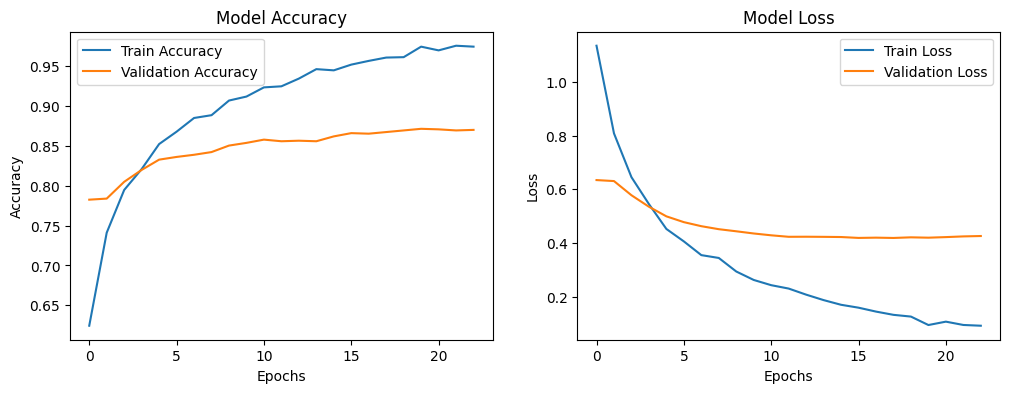

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 242ms/step
                   precision    recall  f1-score   support

        apple_pie       0.81      0.76      0.78       250
   baby_back_ribs       0.95      0.96      0.95       250
          baklava       0.88      0.89      0.89       250
   beef_carpaccio       0.93      0.93      0.93       250
     beef_tartare       0.93      0.90      0.91       250
       beet_salad       0.90      0.89      0.90       250
         beignets       0.94      0.96      0.95       250
         bibimbap       0.98      0.98      0.98       250
    bread_pudding       0.80      0.84      0.82       250
breakfast_burrito       0.92      0.93      0.93       250

         accuracy                           0.90      2500
        macro avg       0.90      0.90      0.90      2500
     weighted avg       0.90      0.90      0.90      2500

=== Initial Training ===
Average Training Accuracy: 0.8622
Average Validation Accuracy: 0.8404
Average Training Loss: 0.4175
Aver

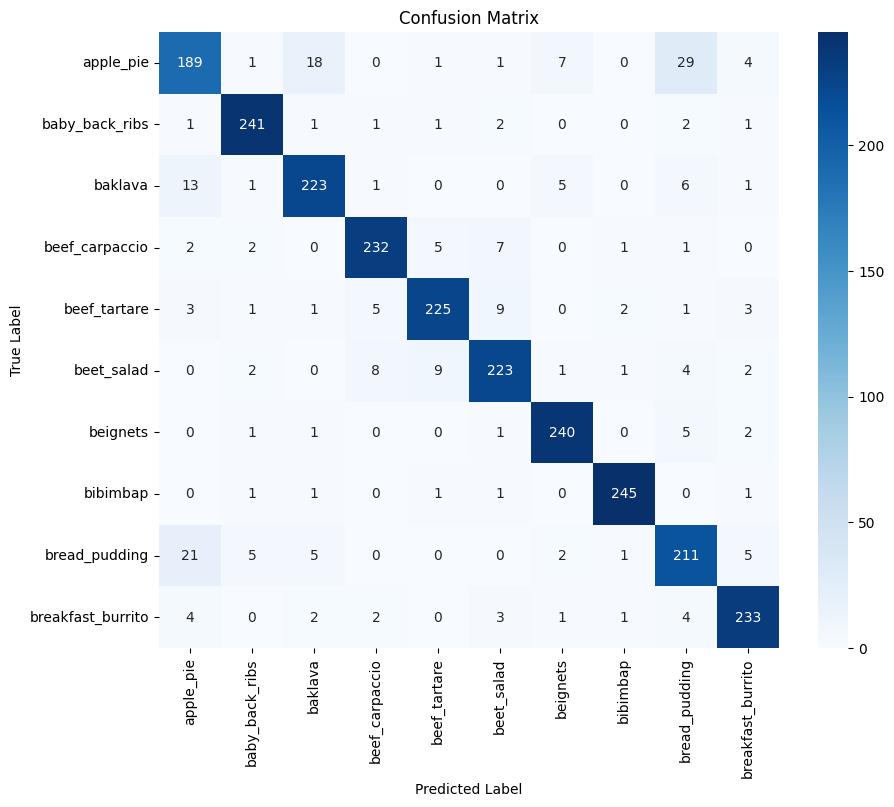

Initial Training Time: 2344.97 seconds
Fine-Tuning Time: 1981.57 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### B4

##### Build Model

In [ ]:
IMG_SIZE = 380
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB4

base_model, model = generate_model(EfficientNetB4)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 380, 380, 3)    │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 381, 381, 3)    │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 190, 190, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 190, 190, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 190, 190, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 190, 190, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 190, 190, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 190, 190, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,135,401 (69.18 MB)

 Trainable params: 461,578 (1.76 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 180s 406ms/step - accuracy: 0.3933 - loss: 1.8243 - val_accuracy: 0.7636 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.7183 - loss: 0.9017 - val_accuracy: 0.8077 - val_loss: 0.6295 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 362ms/step - accuracy: 0.7586 - loss: 0.7489 - val_accuracy: 0.8152 - val_loss: 0.5690 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 387ms/step - accuracy: 0.7917 - loss: 0.6235 - val_accuracy: 0.8227 - val_loss: 0.5297 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 357ms/step - accuracy: 0.8030 - loss: 0.6017 - val_accuracy: 0.8308 - val_loss: 0.5050 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 373ms/step - accuracy: 0.8229 - loss: 0.5298 - val_accuracy: 0.8302 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

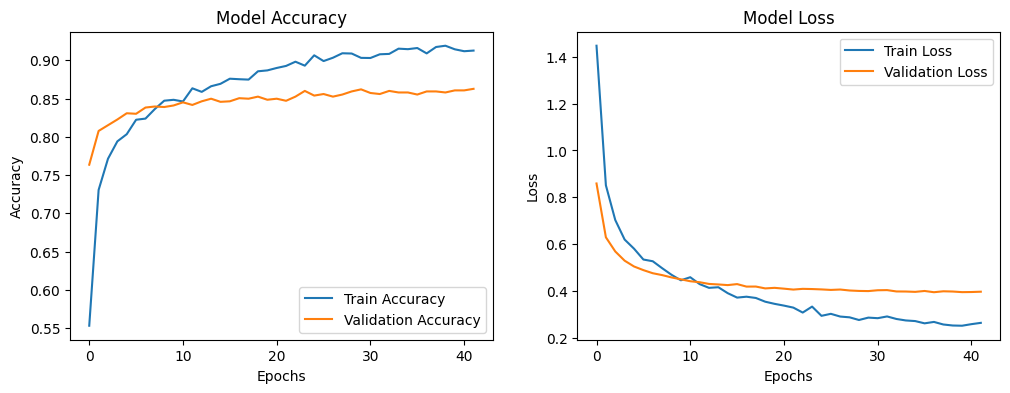

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 432s 949ms/step - accuracy: 0.5778 - loss: 1.2602 - val_accuracy: 0.8091 - val_loss: 0.5738 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 168s 901ms/step - accuracy: 0.7451 - loss: 0.8144 - val_accuracy: 0.8132 - val_loss: 0.5625 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 168s 902ms/step - accuracy: 0.8092 - loss: 0.6247 - val_accuracy: 0.8370 - val_loss: 0.4969 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 169s 908ms/step - accuracy: 0.8464 - loss: 0.5064 - val_accuracy: 0.8533 - val_loss: 0.4484 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 172s 922ms/step - accuracy: 0.8760 - loss: 0.4047 - val_accuracy: 0.8607 - val_loss: 0.4183 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 172s 922ms/step - accuracy: 0.8889 - loss: 0.3605 - val_accuracy: 0.8675 - val_loss: 0.3972 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

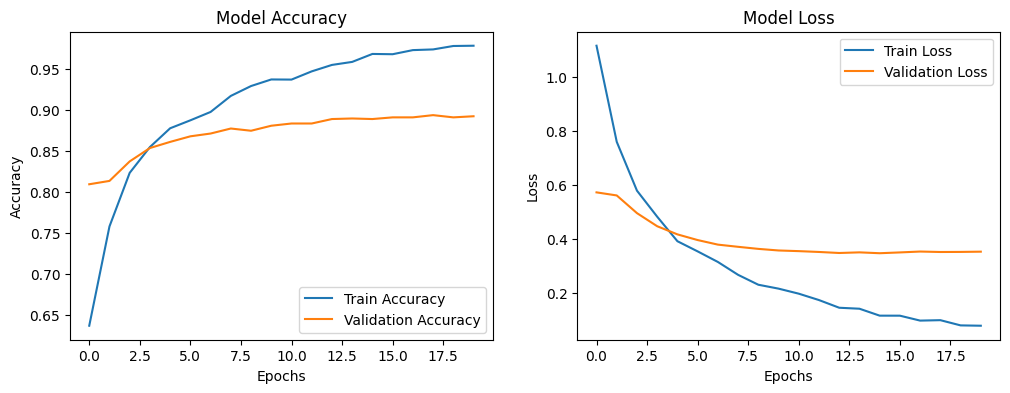

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 326ms/step
                   precision    recall  f1-score   support

        apple_pie       0.83      0.80      0.82       250
   baby_back_ribs       0.96      0.96      0.96       250
          baklava       0.91      0.92      0.91       250
   beef_carpaccio       0.94      0.94      0.94       250
     beef_tartare       0.92      0.91      0.92       250
       beet_salad       0.91      0.90      0.91       250
         beignets       0.94      0.97      0.96       250
         bibimbap       0.97      0.98      0.98       250
    bread_pudding       0.82      0.84      0.83       250
breakfast_burrito       0.95      0.93      0.94       250

         accuracy                           0.92      2500
        macro avg       0.92      0.92      0.92      2500
     weighted avg       0.92      0.92      0.92      2500

=== Initial Training ===
Average Training Accuracy: 0.8688
Average Validation Accuracy: 0.8467
Average Training Loss: 0.4019
Aver

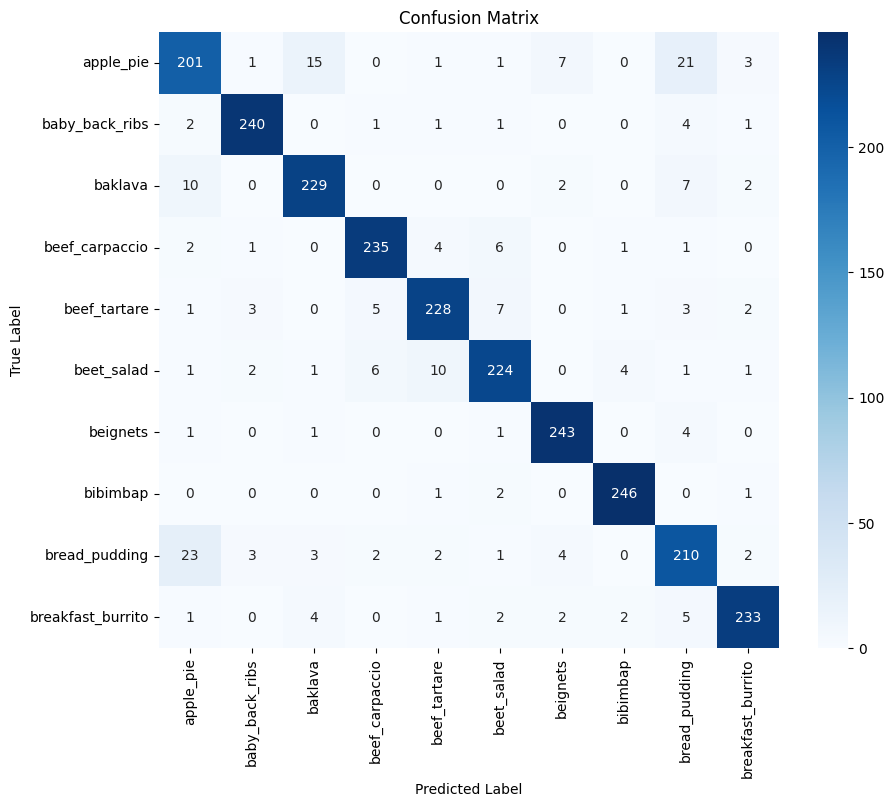

Initial Training Time: 2968.24 seconds
Fine-Tuning Time: 3687.42 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

### EfficientNetV2

#### B0

##### Build Model

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model, model = generate_model(EfficientNetV2B0)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 56, 56, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 56, 56, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 56, 56, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 6,249,818 (23.84 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 115s 241ms/step - accuracy: 0.2715 - loss: 2.0728 - val_accuracy: 0.6963 - val_loss: 1.1726 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 258ms/step - accuracy: 0.6356 - loss: 1.1805 - val_accuracy: 0.7582 - val_loss: 0.8425 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 255ms/step - accuracy: 0.6729 - loss: 0.9794 - val_accuracy: 0.7724 - val_loss: 0.7364 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.7245 - loss: 0.8439 - val_accuracy: 0.7887 - val_loss: 0.6801 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.7430 - loss: 0.7705 - val_accuracy: 0.7996 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.7522 - loss: 0.7234 - val_accuracy: 0.8043 - val_loss: 0.6066 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

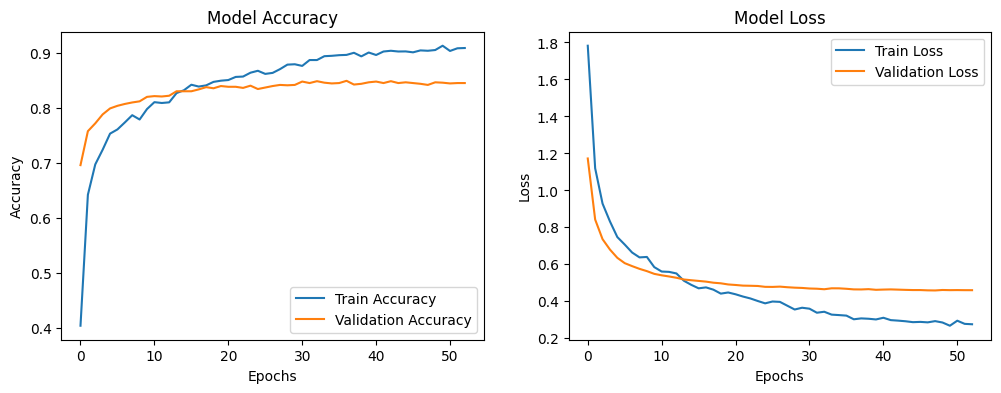

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 163s 235ms/step - accuracy: 0.6056 - loss: 1.1691 - val_accuracy: 0.7235 - val_loss: 0.8843 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - accuracy: 0.6908 - loss: 0.9475 - val_accuracy: 0.7622 - val_loss: 0.7519 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step - accuracy: 0.7527 - loss: 0.7600 - val_accuracy: 0.7792 - val_loss: 0.6817 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 255ms/step - accuracy: 0.7900 - loss: 0.6404 - val_accuracy: 0.8043 - val_loss: 0.6241 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.8097 - loss: 0.6002 - val_accuracy: 0.8186 - val_loss: 0.5763 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 253ms/step - accuracy: 0.8321 - loss: 0.5255 - val_accuracy: 0.8186 - val_loss: 0.5550 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

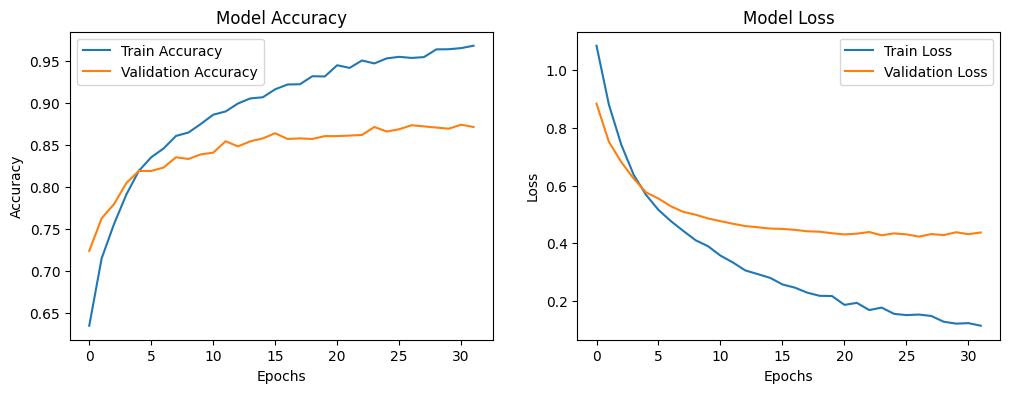

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step
                   precision    recall  f1-score   support

        apple_pie       0.78      0.76      0.77       250
   baby_back_ribs       0.95      0.95      0.95       250
          baklava       0.89      0.92      0.90       250
   beef_carpaccio       0.92      0.95      0.93       250
     beef_tartare       0.92      0.89      0.90       250
       beet_salad       0.91      0.86      0.88       250
         beignets       0.93      0.96      0.94       250
         bibimbap       0.95      0.97      0.96       250
    bread_pudding       0.78      0.81      0.80       250
breakfast_burrito       0.95      0.89      0.92       250

         accuracy                           0.90      2500
        macro avg       0.90      0.90      0.90      2500
     weighted avg       0.90      0.90      0.90      2500

=== Initial Training ===
Average Training Accuracy: 0.8451
Average Validation Accuracy: 0.8309
Average Training Loss: 0.4637
Aver

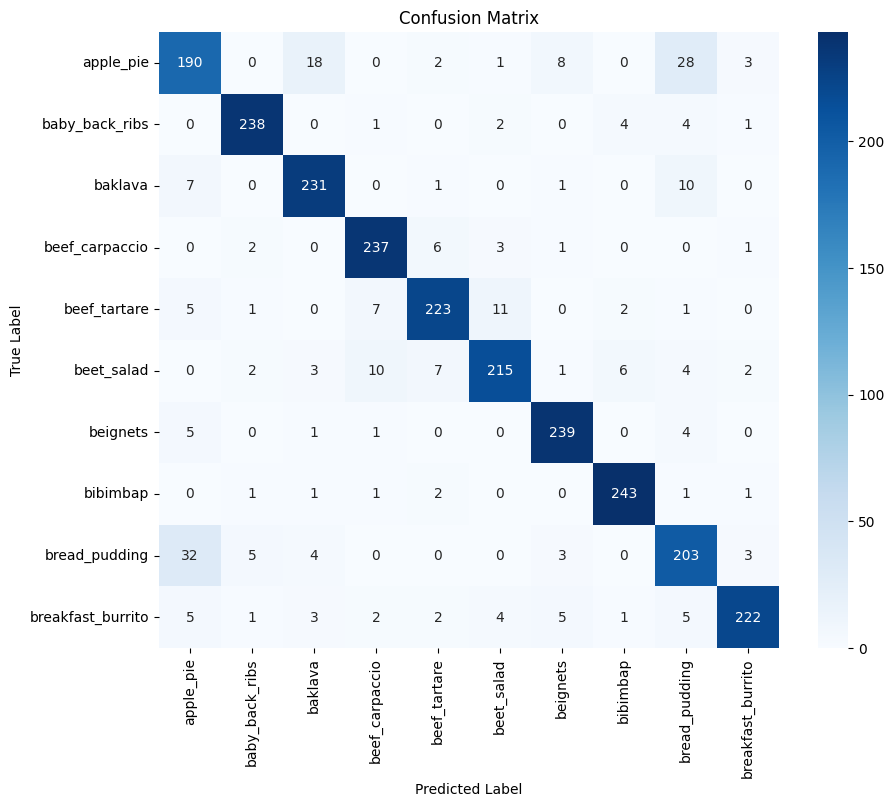

Initial Training Time: 2459.27 seconds
Fine-Tuning Time: 1631.60 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### B2

##### Build Model

In [ ]:
IMG_SIZE = 260
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B2

base_model, model = generate_model(EfficientNetV2B2)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 260, 260, 3)    │              0 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 130, 130, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 130, 130, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 130, 130, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 130, 130, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 130, 130, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 130, 130, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 130, 130, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 130, 130, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 9,132,648 (34.84 MB)

 Trainable params: 363,274 (1.39 MB)

 Non-trainable params: 8,769,374 (33.45 MB)

##### Train Model (Before Fine-Tuning)

In [ ]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [ ]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 121s 249ms/step - accuracy: 0.3074 - loss: 2.0124 - val_accuracy: 0.7296 - val_loss: 1.0351 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - accuracy: 0.6322 - loss: 1.1473 - val_accuracy: 0.7738 - val_loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - accuracy: 0.7075 - loss: 0.8992 - val_accuracy: 0.7921 - val_loss: 0.6703 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - accuracy: 0.7152 - loss: 0.8341 - val_accuracy: 0.8003 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 550ms/step - accuracy: 0.7406 - loss: 0.7697 - val_accuracy: 0.8091 - val_loss: 0.5899 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 258ms/step - accuracy: 0.7482 - loss: 0.7241 - val_accuracy: 0.8057 - val_loss: 0.5748 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

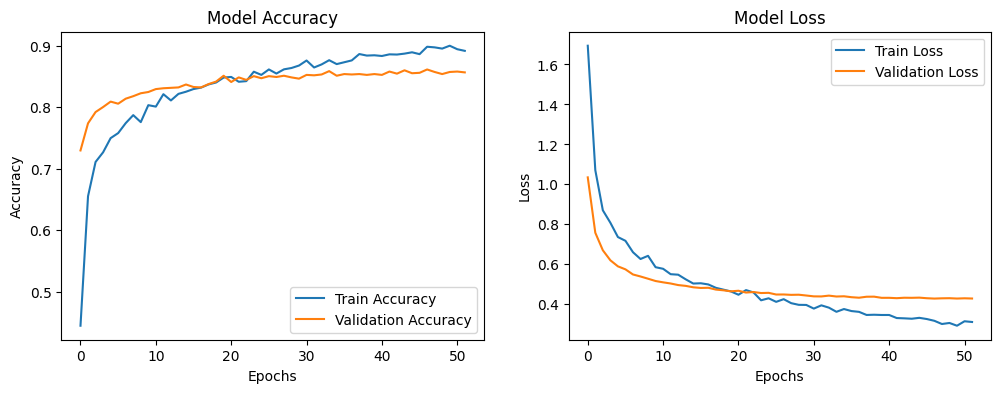

In [ ]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [ ]:
model = fine_tune_model(base_model, model)

In [ ]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 209s 305ms/step - accuracy: 0.6264 - loss: 1.1572 - val_accuracy: 0.7622 - val_loss: 0.7889 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 296ms/step - accuracy: 0.7285 - loss: 0.8700 - val_accuracy: 0.8003 - val_loss: 0.6397 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.7770 - loss: 0.7052 - val_accuracy: 0.8166 - val_loss: 0.5618 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 298ms/step - accuracy: 0.8115 - loss: 0.6024 - val_accuracy: 0.8281 - val_loss: 0.5151 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.8423 - loss: 0.5266 - val_accuracy: 0.8417 - val_loss: 0.4782 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.8459 - loss: 0.4715 - val_accuracy: 0.8492 - val_loss: 0.4584 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

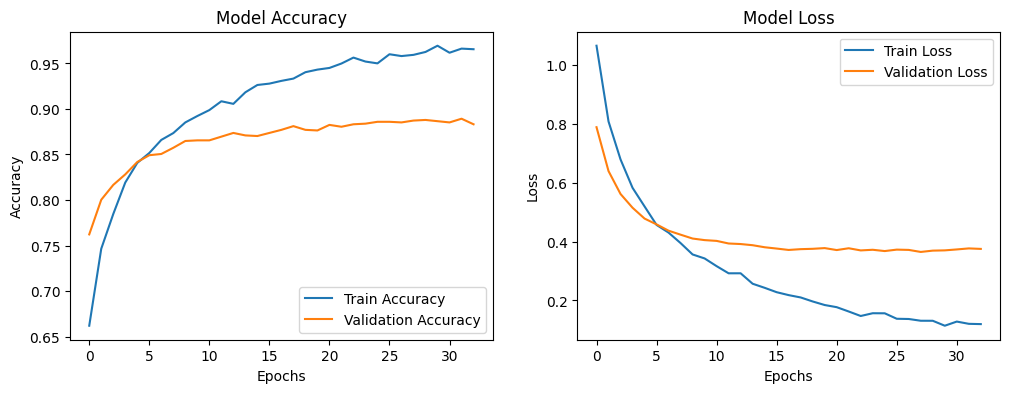

In [ ]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step
                   precision    recall  f1-score   support

        apple_pie       0.84      0.76      0.80       250
   baby_back_ribs       0.96      0.97      0.97       250
          baklava       0.92      0.93      0.92       250
   beef_carpaccio       0.96      0.94      0.95       250
     beef_tartare       0.93      0.94      0.93       250
       beet_salad       0.91      0.92      0.91       250
         beignets       0.95      0.97      0.96       250
         bibimbap       0.96      0.98      0.97       250
    bread_pudding       0.79      0.87      0.83       250
breakfast_burrito       0.97      0.92      0.94       250

         accuracy                           0.92      2500
        macro avg       0.92      0.92      0.92      2500
     weighted avg       0.92      0.92      0.92      2500

=== Initial Training ===
Average Training Accuracy: 0.8358
Average Validation Accuracy: 0.8392
Average Training Loss: 0.4867
Aver

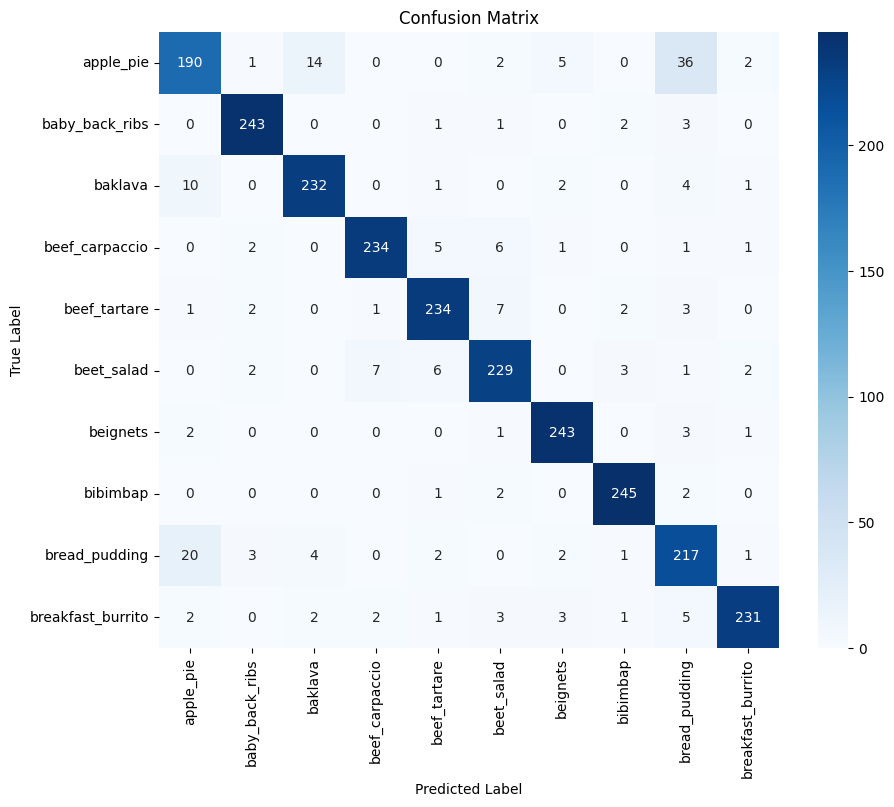

Initial Training Time: 2617.98 seconds
Fine-Tuning Time: 1962.67 seconds


In [ ]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)

#### S

##### Build Model

In [20]:
IMG_SIZE = 384
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [21]:
from tensorflow.keras.applications import EfficientNetV2S

base_model, model = generate_model(EfficientNetV2S)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 384, 384, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 192, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 192, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 192, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 192, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 192, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 192, 192, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 192, 192, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 192, 192, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 192, 192, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 192, 192, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 192, 192, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 192, 192, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 20,661,866 (78.82 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

##### Train Model (Before Fine-Tuning)

In [22]:
# Processing Dataset
train_set, val_set, test_set = pipeline_preprocessing()

In [23]:
history, initial_training_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 184s 349ms/step - accuracy: 0.3469 - loss: 1.9158 - val_accuracy: 0.7412 - val_loss: 0.9366 - learning_rate: 1.0000e-04
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 59s 319ms/step - accuracy: 0.6797 - loss: 0.9923 - val_accuracy: 0.8037 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 322ms/step - accuracy: 0.7400 - loss: 0.8020 - val_accuracy: 0.8050 - val_loss: 0.5936 - learning_rate: 1.0000e-04
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 321ms/step - accuracy: 0.7564 - loss: 0.7127 - val_accuracy: 0.8247 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 320ms/step - accuracy: 0.7766 - loss: 0.6702 - val_accuracy: 0.8315 - val_loss: 0.5174 - learning_rate: 1.0000e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 59s 319ms/step - accuracy: 0.8123 - loss: 0.5829 - val_accuracy: 0.8383 - val_loss: 0.4924 - learning_rate: 1.0000e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

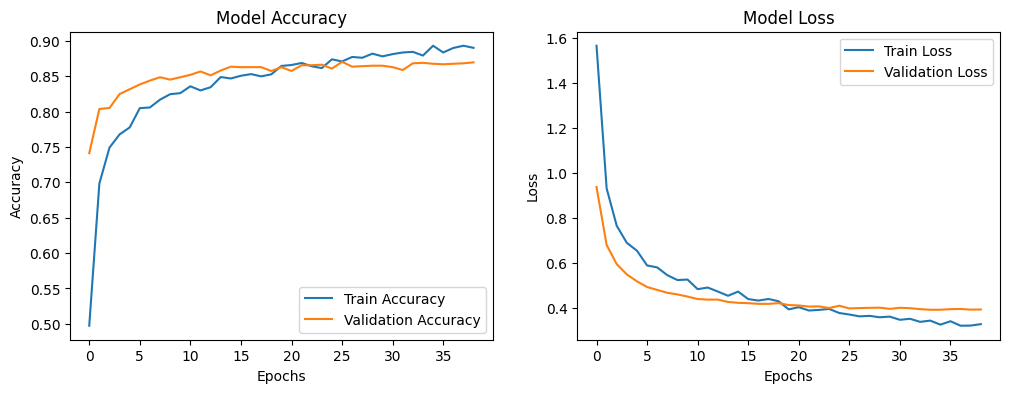

In [24]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [25]:
model = fine_tune_model(base_model, model)

In [26]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_set, val_set)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 335s 642ms/step - accuracy: 0.5929 - loss: 1.2294 - val_accuracy: 0.7751 - val_loss: 0.7296 - learning_rate: 1.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 109s 583ms/step - accuracy: 0.7353 - loss: 0.8239 - val_accuracy: 0.8213 - val_loss: 0.5588 - learning_rate: 1.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 108s 581ms/step - accuracy: 0.8042 - loss: 0.6087 - val_accuracy: 0.8438 - val_loss: 0.4933 - learning_rate: 1.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 107s 571ms/step - accuracy: 0.8539 - loss: 0.4893 - val_accuracy: 0.8519 - val_loss: 0.4506 - learning_rate: 1.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 107s 573ms/step - accuracy: 0.8607 - loss: 0.4335 - val_accuracy: 0.8607 - val_loss: 0.4283 - learning_rate: 1.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 107s 571ms/step - accuracy: 0.8812 - loss: 0.3729 - val_accuracy: 0.8655 - val_loss: 0.4091 - learning_rate: 1.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━

###### Accuracy and Loss Graph

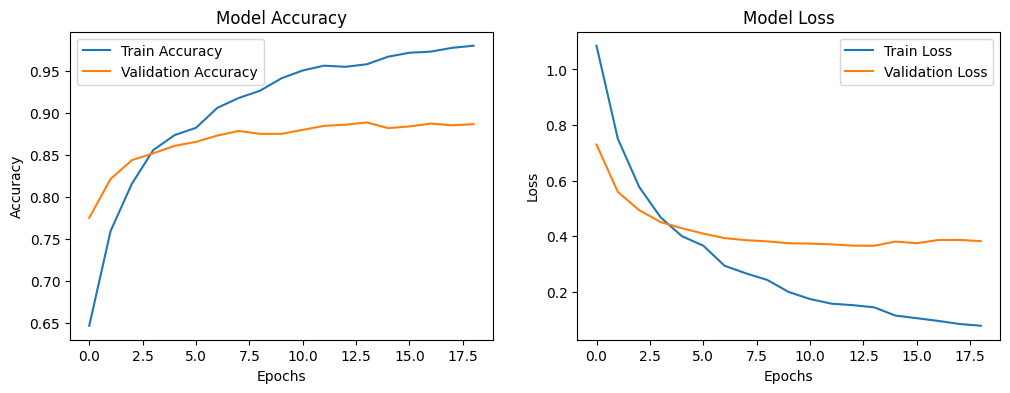

In [27]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 271ms/step
                   precision    recall  f1-score   support

        apple_pie       0.78      0.80      0.79       250
   baby_back_ribs       0.98      0.94      0.96       250
          baklava       0.89      0.92      0.91       250
   beef_carpaccio       0.90      0.94      0.92       250
     beef_tartare       0.93      0.91      0.92       250
       beet_salad       0.93      0.89      0.91       250
         beignets       0.93      0.96      0.95       250
         bibimbap       0.96      0.98      0.97       250
    bread_pudding       0.85      0.80      0.82       250
breakfast_burrito       0.96      0.94      0.95       250

         accuracy                           0.91      2500
        macro avg       0.91      0.91      0.91      2500
     weighted avg       0.91      0.91      0.91      2500

=== Initial Training ===
Average Training Accuracy: 0.8392
Average Validation Accuracy: 0.8528
Average Training Loss: 0.4780
Aver

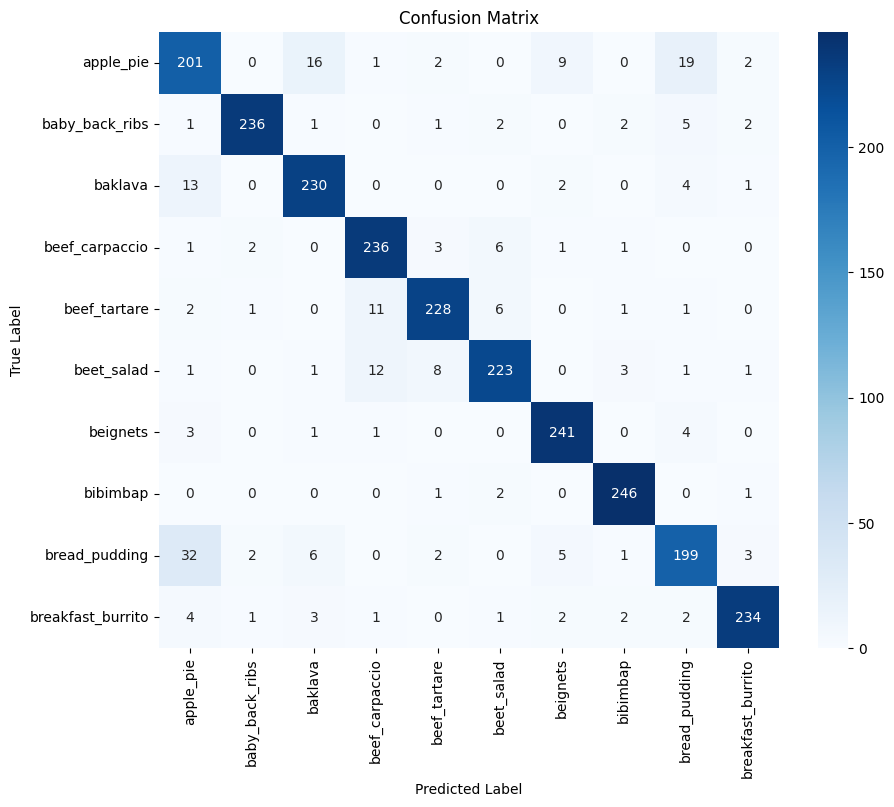

Initial Training Time: 2430.89 seconds
Fine-Tuning Time: 2261.49 seconds


In [28]:
gen_report(model, test_set, history, fine_tune_history, initial_training_time, fine_tuning_time)